In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import scale

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd.gradcheck import zero_gradients
from torch import autograd

In [24]:
path = "F:\JupyterNotebook_Dir\REAM _Lab\CCPP\CCPP\Folds5x2_pp.xlsx"
data = pd.read_excel(path)



data_AT = data["AT"].values;data_V = data["V"].values
data_AP = data["AP"].values;data_RH = data["RH"];data_PE = data["PE"].values
data=np.vstack((data_AT,data_V,data_AP,data_RH))
data=data.T

#data pre-processing
scaler1 = StandardScaler()
scaler2 = MaxAbsScaler()

data_standard = scaler1.fit_transform(data)
# data_standard = scaler2.fit_transform(data_standard)
#data_PE=data_PE.T
X_train, X_test, y_train, y_test = train_test_split(data_standard, data_PE, test_size=0.33)

In [25]:
print(np.max(data_standard))
print(np.min(data_standard))

3.37475991493086
-3.4300192947559176


# Neural Network

In [26]:
x_ts=torch.from_numpy(X_train)
y_ts=torch.from_numpy(y_train)
x_test_ts=torch.from_numpy(X_test)
y_test_ts=torch.from_numpy(y_test)
n_train = y_train.shape[0]
n_test = y_test.shape[0]
y_ts=y_ts.reshape(n_train,1)
y_test_ts = y_test_ts.reshape(n_test,1)
x=Variable(x_ts)

In [27]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = torch.nn.Linear(4,8) 
        self.linear2 = torch.nn.Linear(8,6)
        self.predict = torch.nn.Linear(6,1)
        
    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out =self.predict(out)
        return out
    
model = Model().double()
model_pca = Model().double()

model

Model(
  (linear1): Linear(in_features=4, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=6, bias=True)
  (predict): Linear(in_features=6, out_features=1, bias=True)
)

In [28]:
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-5)
loss_func = torch.nn.MSELoss()

h_list = []
l_list = []
for epoch in range(3000):
    # forward
    y_pred = model(x)
    loss = loss_func(y_pred,y_ts)
   # print(epoch, loss.item())
    h_list.append(epoch)
    l_list.append(loss.item())
    
    # back propagation
    optimizer.zero_grad()
    loss.backward()
    # updating parameters
    optimizer.step()

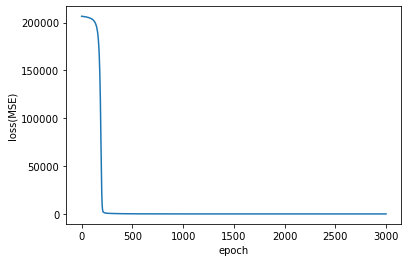

In [29]:
plt.plot(h_list, l_list)
plt.ylabel('loss(MSE)')
plt.xlabel('epoch')
plt.show()

r2_score is 0.9382421688953537
MSE is 18.340733765652757


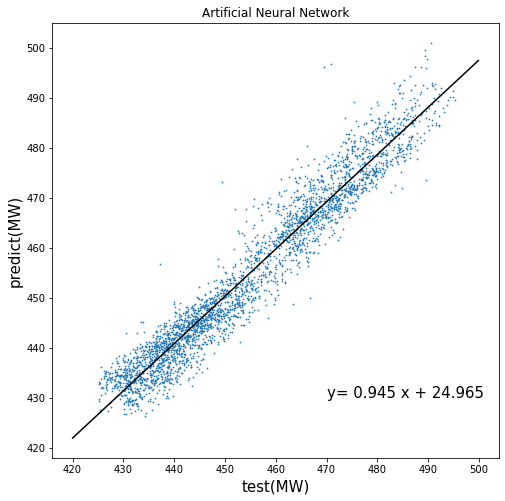

In [30]:
y_test_model=model(x_test_ts)
y_predict=y_test_model.detach().numpy()
plt.figure(figsize=(8,8))
plt.xlabel('test(MW)',fontsize=15)
plt.ylabel('predict(MW)',fontsize=15)
plt.scatter(y_test,y_predict,s=0.5)

z5 = np.polyfit(y_test,y_predict,1)  #Linear fitting
x5 = np.arange(420, 500, 0.1)
y5 = x5 * z5[0]+z5[1]
plt.plot(x5, y5,'black')
z6 = np.polyfit(y_test,y_predict,1)  #Linear fitting
plt.text(470,430,'y= %.3f x + %.3f'%(z6[0],z6[1]),fontsize=15)
plt.title('Artificial Neural Network')
r_ANN=r2_score(y_test,y_predict)
print('r2_score is %s'%r_ANN)
MSE_ANN = mean_squared_error(y_test,y_predict)
print('MSE is %s'%MSE_ANN)

# Train a GAN model

In [31]:
# define the discriminator
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.dis = nn.Sequential(
            nn.Linear(4, 18), 
            nn.LeakyReLU(0.2),  
            nn.Linear(18, 18),  
            nn.LeakyReLU(0.2),
            nn.Linear(18, 1),
            nn.Sigmoid()  
            
        )
 
    def forward(self, x):
        x = self.dis(x)
        return x

class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(3, 18),  
            nn.ReLU(True),  
            nn.Linear(18, 18),  
            nn.ReLU(True), 
            nn.Linear(18, 18),  
            nn.ReLU(True), 
            nn.Linear(18, 4), 
            nn.Tanh()  
        )
 
    def forward(self, x):
        x = self.gen(x)
        return x


D = discriminator()
G = generator()
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

In [32]:
batch_size = 500
num_epoch = 5000


criterion = nn.BCELoss()  
d_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3)
g_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)


d_loss_list = []
g_loss_list = []


for epoch in range(num_epoch):
   
    num_train = x_ts.size(0)
    dim = x_ts.size(1)
    dim_noise = 3
    # =============================Discriminator training==================
    real_label = Variable(torch.ones(num_train))  # Define real samples as 1
    fake_label = Variable(torch.zeros(num_train)) # Define fake samples as 0

    # Two parts: 1. Distinguish real samples as real. 2.Distinguish fake samples as fake.
    # Compute the loss of the real samples
    real_out = D(x_ts.float())  
    d_loss_real = criterion(real_out, real_label)  # loss of real samples
    real_scores = real_out  
    # Compute the loss of the fake samples
    z = Variable(torch.randn(num_train, dim_noise))  # Generate random noise
    fake_samples = G(z).detach()  # Generating fake samples using random noise # Gradient detached as G is not updated here
    fake_out = D(fake_samples)  
    d_loss_fake = criterion(fake_out, fake_label)  # loss of fake samples
    fake_scores = fake_out 
    # Optimize the loss function
    d_loss = d_loss_real + d_loss_fake  
    d_optimizer.zero_grad()  
    d_loss.backward(d_loss)  
    d_loss_list.append(d_loss)
    d_optimizer.step()  # Update parameters

    # =============================Generator training==================
    z = Variable(torch.randn(num_train, dim_noise))  # Generate random noise
    fake_samples = G(z)  
    output = D(fake_samples)  
    g_loss = criterion(output, real_label)  # Loss of fake samples and real labels
    # bp and optimize
    g_optimizer.zero_grad()  
    g_loss.backward()  
    g_loss_list.append(g_loss)
    g_optimizer.step() 
    
    
    
    if epoch % 100 == 0:
        print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
              'D real: {:.6f},D fake: {:.6f}'.format(
            epoch, num_epoch, d_loss.data.item(), g_loss.data.item(),
            real_scores.data.mean(), fake_scores.data.mean()  # print the loss of real samples
        ))


F:\Anaconda\envs\python385\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([6410])) that is different to the input size (torch.Size([6410, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch[0/5000],d_loss:1.407146,g_loss:0.684739 D real: 0.495135,D fake: 0.505085
Epoch[100/5000],d_loss:0.979110,g_loss:0.918365 D real: 0.639400,D fake: 0.400792
Epoch[200/5000],d_loss:0.479394,g_loss:1.484795 D real: 0.834856,D fake: 0.229973
Epoch[300/5000],d_loss:0.340798,g_loss:1.916349 D real: 0.873856,D fake: 0.153187
Epoch[400/5000],d_loss:0.293965,g_loss:2.125346 D real: 0.888830,D fake: 0.124436
Epoch[500/5000],d_loss:0.284302,g_loss:2.294998 D real: 0.895990,D fake: 0.111618
Epoch[600/5000],d_loss:0.340855,g_loss:2.359863 D real: 0.872674,D fake: 0.124095
Epoch[700/5000],d_loss:0.304979,g_loss:2.464931 D real: 0.888568,D fake: 0.111375
Epoch[800/5000],d_loss:0.275333,g_loss:2.620652 D real: 0.901493,D fake: 0.097289
Epoch[900/5000],d_loss:0.246762,g_loss:2.640249 D real: 0.911580,D fake: 0.084771
Epoch[1000/5000],d_loss:0.267102,g_loss:2.576918 D real: 0.912470,D fake: 0.091856
Epoch[1100/5000],d_loss:0.247090,g_loss:2.729353 D real: 0.918567,D fake: 0.083477
Epoch[1200/5000]

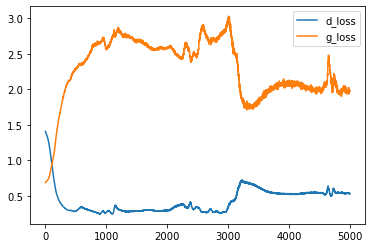

In [33]:
plt.plot(range(num_epoch),d_loss_list,label = 'd_loss')
plt.plot(range(num_epoch),g_loss_list,label = 'g_loss')
plt.legend()

# Test GAN model

In [34]:
z = Variable(torch.randn(y_test_ts.shape[0], dim_noise))  # Generate random noise
z.requires_grad = True
x_gen = G(z) 
y_gen_pred = model(x_gen.double())
loss = loss_func(y_test_ts,y_gen_pred) 
loss.backward() 
print(z.grad)
print(z.requires_grad)

tensor([[ 2.7698e-01, -8.3296e-02, -4.0579e-02],
        [-4.1247e-05,  5.6140e-05, -1.6684e-05],
        [-1.4962e-01,  1.1834e-01, -3.0403e-02],
        ...,
        [ 1.4658e-01, -1.0653e-01,  3.6311e-02],
        [ 2.6819e-02, -1.9830e-02, -1.5577e-03],
        [ 1.4537e-01, -1.3740e-01, -1.1676e-02]])
True


In [35]:
num_iter = 1000
loss_func = torch.nn.MSELoss()
lr = 1e4

r2_list = []

z = Variable(torch.randn(y_test_ts.shape[0], dim_noise))  # Generate random noise
z.requires_grad = True

for i in range(num_iter):
    z.retain_grad()
    x_gen = G(z)
    
#     y_gen_pred = model(x_gen.double())
#     loss = loss_func(y_test_ts,y_gen_pred) 
    
    loss = loss_func(x_test_ts,x_gen) 
    loss.backward(retain_graph=True)  
    z = z-lr*z.grad
    
    y_gen_pred = model(x_gen.double())
    r2 = r2_score(y_test_ts.detach().numpy(),y_gen_pred.detach().numpy())
    r2_list.append(r2)
    
    

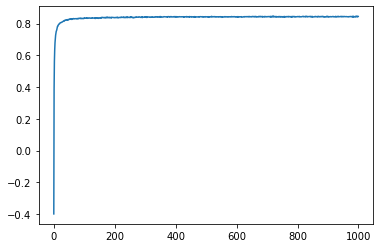

In [36]:
plt.plot(range(num_iter),r2_list)
